## Exploring lapse rate trends over different time scales and in correlation with other met variables.

In [1]:
# ====================
# Do initial LR 
# exploration
# ====================

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import matplotlib.dates as mdates
# set up
pd.plotting.register_matplotlib_converters()
plt.style.use('ggplot')

# data folder
format_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\DATA'

#%%
# --- Load dataframes
dtvg = pd.read_pickle(os.path.join(format_data,'daily_tavg.pickle'))
meta = pd.read_pickle(os.path.join(format_data,'temperature_meta.pickle'))

### Useful functions

In [2]:
#%%
# ---- calculate lapse rates for summer

def lr_ix(df):
    """ put seasonal index into dataframe for use in splitting data into melt and non-melt seasons"""
    seasons = {'melt': [4,5,6,7,8,9,10], # April - November
               'non-melt': [1,2,3,11,12]}
    months = {num:sea for sea in seasons.keys()
                            for num in seasons[sea]}
    # name winter according to year which it starts
    sea = pd.Series(df.index.month).map(months)
    # put back into dataframe
    seaidx = pd.Index(sea,name='MELT')
    df = df.set_index(seaidx,append=True)
    
    return df

def lr_plot(daily,freq, drop_buri=True,plot=True):
    """ daily is the daily dataframe, freq is the frequency period to
    resample over. Also returns melt dataframe."""
    
    if freq != 'D':
        # resample
        df = daily.resample(freq).mean()
    else:
        df = daily.copy()
    # add melt season index in
    df = lr_ix(df)
    # subset just melt season out, drop index
    idx = pd.IndexSlice
    melt = df.copy()
    melt.loc[idx[:,'non-melt'],:] = np.nan # turn non-melt values to nan
    if drop_buri:
        melt = melt.drop(['buri'],axis=1) # drop buri for now
    
    melt = melt.reset_index(level=1,drop=True) # drop melt index
    # calculate lapse rate (high minus low) C per km
    melt['lapse'] = 1000 * (melt['gates'] - melt['usgs']) / (meta.el['gates'][0] - meta.el['usgs'][0])
    
    if plot:# plot
        plt.close()
        melt.lapse.plot()
    
    return melt

### To get a sense of the lapse rate distribution, we can look at boxplots via all data or via season

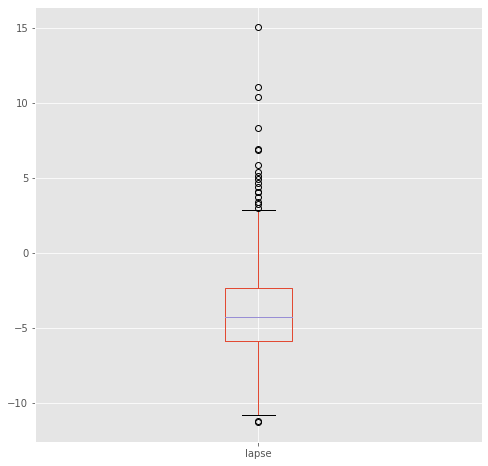

In [3]:
# boxplot for all weekly lapse rates 
melt = lr_plot(dtvg,'D',plot=False)
melt.lapse.plot(kind='box', figsize=(8,8)) 


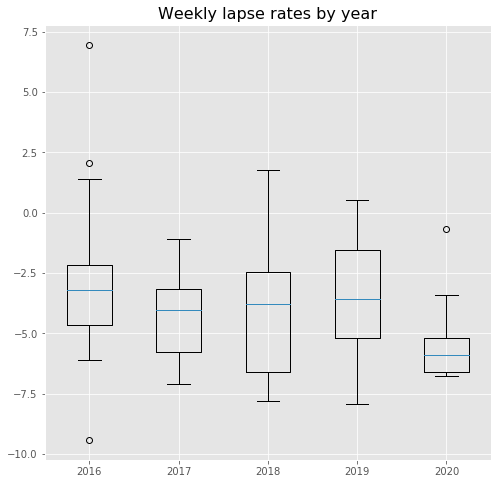

In [8]:
# boxplot by summer season
years = [2016,2017,2018,2019,2020]
data = []
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title('Weekly lapse rates by year',fontsize=16)
# put data into list for plotting
for year in years:
    # remove nan rows
    melt = melt.dropna(subset=['lapse'])
    cut = melt[melt.index.year == year]['lapse']
    data.append(np.array(cut)) # just keep lapse values, not index
   
ax.boxplot(data)
ax.set_xticklabels(str(y) for y in years)
plt.show() 
   



## Lapse rate correlations with met parameters

### 1. Air temperatures (TAVG)

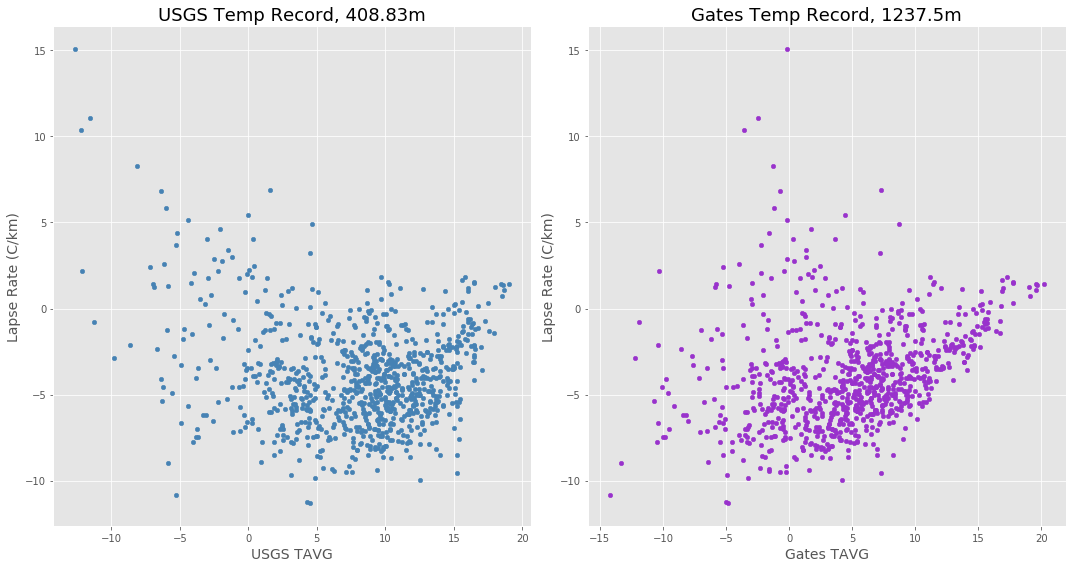

In [4]:
# temps subplots for weekly averaged lapse rates
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,8))
# usgs
ax1.scatter(melt['usgs'],melt['lapse'],color='steelblue',s=20)
ax1.set_title('USGS Temp Record, {}m'.format(meta.el['usgs'][0]),fontsize=18)
ax1.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax1.set_xlabel('USGS TAVG',fontsize=14)
# gates
ax2.scatter(melt['gates'],melt['lapse'],color='darkorchid',s=20)
ax2.set_title('Gates Temp Record, {}m'.format(meta.el['gates'][0]),fontsize=18)
ax2.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax2.set_xlabel('Gates TAVG',fontsize=14)
fig.tight_layout()
plt.show()

### Since the lapse rates appear to be marginally more correlated with Gates Glacier temperatures, we can examine the relationship for temperatures > 0 degrees

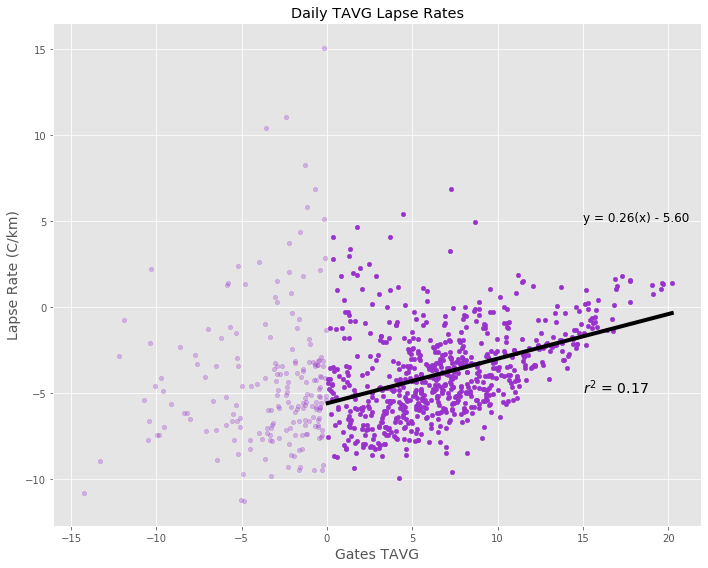

In [5]:
# --- regress LR with just gates temps
above = pd.DataFrame(data={'gates': melt['gates'].loc[melt['gates']>= 0],
                           'lapse': melt['lapse'].loc[melt['gates']>= 0]})
# plot up
fig,ax = plt.subplots(figsize=(10,8))
# data points
x,y = above['gates'],above['lapse']
ax.scatter(x,y,color='darkorchid',s=20)
ax.scatter(melt['gates'].loc[melt['gates']< 0], melt['lapse'].loc[melt['gates'] < 0],
           color='darkorchid',s=20, alpha=0.3)
# regression
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
r2 = r_value**2
xo = np.linspace(x.min(),x.max(),)
Yhat = (slope*xo) + intercept # regression y coords
ax.plot(xo,Yhat,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
ax.annotate('$r^2$ = {:.2f}'.format(r2),(15,-5),fontsize=14)
ax.annotate('y = {0:.2f}(x) - {1:.2f}'.format(slope,-intercept),(15,5),fontsize=12)
# labels
ax.set_title('Daily TAVG Lapse Rates')
ax.set_ylabel('Lapse Rate (C/km)',fontsize=14)
ax.set_xlabel('Gates TAVG',fontsize=14)
fig.tight_layout()
plt.show()

### Here, we can see that the relationship is not actually that good (r2=0.17) and does not appear to really be linear. Some of the other statistical assumptions don't look good either.

### Normality of Lapse Rate values: this actually looks pretty good. 

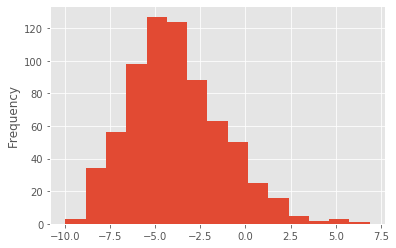

In [6]:
plt.figure()
above['lapse'].plot(kind='hist',bins=15)
plt.show()

### Variance and errors


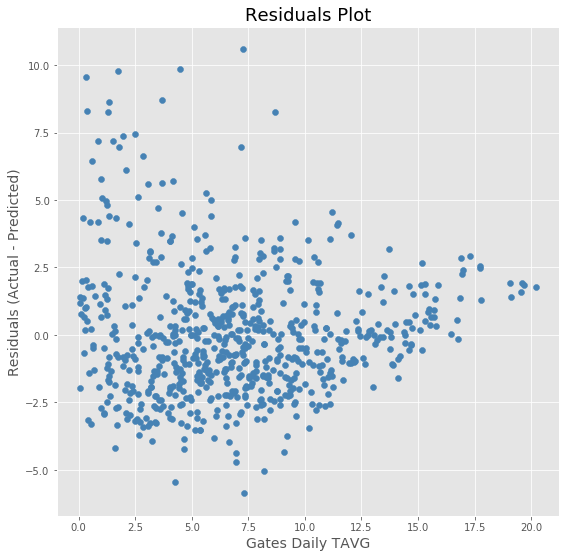

In [7]:
# calculate new Yhat with all x 
Yxhat = (slope*x) + intercept # regression-precicted y coords
res = y - Yxhat #  actual - predicted

# --- Residuals Plot
fig,ax = plt.subplots(figsize=(9,9))
ax.set_title('Residuals Plot',fontsize=18)
ax.scatter(x,res,color='steelblue')
ax.set_ylabel('Residuals (Actual - Predicted)',fontsize=14)
ax.set_xlabel('Gates Daily TAVG',fontsize=14)
plt.show()


### Not so good...the variance is absolutely heteroskedastic and appears to scale with Gates TAVG. 

### Bottom line, given the poor relationship between temperature and lapse rate, and the violation of equal variance and independence of residuals, it doesn't make much sense to scale lapse rates with gates glacier TAVG. Instead, it may be more worthwhile to investigate correlations between lapse rate and other met variables, such as wind speed, humidity, precipitation, lR, etc. 

### For now, I will continue ahead with the median lapse rate value for lapse rates when Gates temperature > 0.

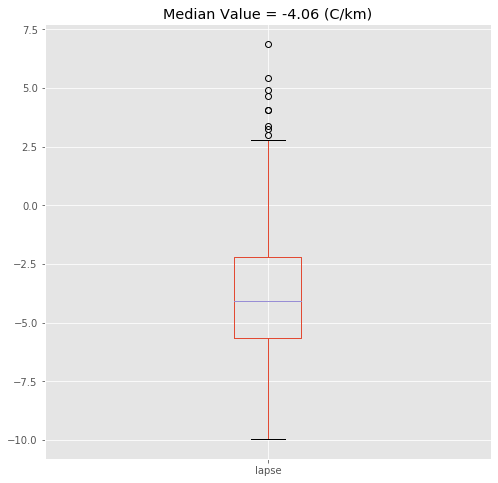

In [8]:
# boxplot
plt.figure(figsize=(8,8))
above['lapse'].plot(kind='box',title='Median Value = {0:.2f} (C/km)'.format(np.nanmedian(above['lapse'])))
plt.show()
